## Metis Project 2 - Predicting Market Values of Soccer Players in the Top 5 European Leagues Using Linear Regression

### 1. Data Cleaning 

In [1]:
import model_utils as mu
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('../Data/player_stats_values.csv')

### 1.1. Convert market values to Million USD, and check for NaNs

In [3]:
df['Market Value (Mil USD)'] = df['Current Market Value (USD)']/1000000

In [4]:
df.drop('Current Market Value (USD)', axis=1, inplace=True)

In [5]:
df[df.isnull().any(axis=1)]

,Player Name,League,Position,Age,Matches Played,Starts,90s Played,Goals,Assists,Yellow Cards,Red Cards,Total Shots,Shots on Target,Passes Completed,Passes Attempted,Key Passes,Completed Passes into PA,Players Dribbled Past,Dribbles into PA,Market Value (Mil USD)


### 1.2. Drop players who have fewer than 10 matches played over three seasons - that's less than 10% of total matches played

In [6]:
df.drop(df[df['Matches Played']<10].index, inplace=True)

### 1.3. Drop goalkeepers as they have completely different attributes/stats

In [7]:
df.drop(df[df['Position']=='GK'].index, inplace=True)

In [8]:
df.describe()

,Age,Matches Played,Starts,90s Played,Goals,Assists,Yellow Cards,Red Cards,Total Shots,Shots on Target,Passes Completed,Passes Attempted,Key Passes,Completed Passes into PA,Players Dribbled Past,Dribbles into PA,Market Value (Mil USD)
count,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000,1742.000000
mean,26.508611,61.935706,48.730195,48.411366,7.135476,4.922503,9.396096,0.480482,62.966131,21.390930,1818.229621,2271.311137,45.828932,40.828358,55.524684,19.770379,13.661110
std,4.073800,33.001391,31.462232,30.508791,11.329893,6.028772,7.535049,0.851676,69.274699,27.436489,1496.786762,1768.371823,48.297488,45.166535,57.212777,29.718864,18.587395
min,17.000000,10.000000,0.000000,1.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.220000
25%,23.000000,34.000000,21.000000,21.500000,1.000000,1.000000,4.000000,0.000000,16.000000,4.000000,649.000000,827.000000,11.000000,10.000000,15.000000,2.000000,2.750000
50%,26.000000,61.000000,45.000000,45.400000,3.000000,3.000000,8.000000,0.000000,40.000000,12.000000,1411.500000,1837.000000,28.000000,25.000000,38.000000,9.000000,6.600000
75%,29.000000,89.000000,73.000000,71.475000,8.000000,7.000000,13.000000,1.000000,84.000000,27.000000,2630.250000,3303.500000,65.000000,57.000000,75.000000,25.000000,16.500000
max,39.000000,177.000000,171.000000,166.400000,106.000000,53.000000,51.000000,5.000000,611.000000,285.000000,9907.000000,11677.000000,342.000000,473.000000,616.000000,249.000000,198.000000


### 1.4. Standardize a player's position to his primary position if they have multiple

In [9]:
df['Position'].value_counts()

DF       639
MF       380
FW       256
FW,MF    189
MF,FW    153
DF,MF     45
MF,DF     45
FW,DF     18
DF,FW     17
Name: Position, dtype: int64

In [10]:
df.loc[306,'Position'] = 'MF'
df.loc[484,'Position'] = 'FW'
df.loc[893,'Position'] = 'MF'
df.loc[1225,'Position'] = 'MF'
df.loc[1538,'Position'] = 'MF'
df.loc[468,'Position'] = 'MF'

In [11]:
df['Position'] = df['Position'].apply(lambda x:x.split(',')[0] if len(x)>2 else x)

In [12]:
df['Position'].value_counts()

DF    698
MF    580
FW    464
Name: Position, dtype: int64

In [13]:
df.reset_index(drop=True, inplace=True)

### 2. Feature Engineering - add standardized and implied numerical stats 

In [14]:
df_standardized = df.copy()

In [15]:
df_standardized['% of Matches Started'] = (df_standardized['Starts'] / df_standardized['Matches Played'])
df_standardized['Goals/90'] = (df_standardized['Goals'] / df_standardized['90s Played'])
df_standardized['Assists/90'] = (df_standardized['Assists'] / df_standardized['90s Played'])
df_standardized['Shots on Target %'] = (df_standardized['Shots on Target'] / df_standardized['Total Shots'])
df_standardized['Goals/SoT %'] = (df_standardized['Goals'] / df_standardized['Shots on Target'])
df_standardized['Pass Comp Rate %'] = (df_standardized['Passes Completed'] / df_standardized['Passes Attempted'])
df_standardized['Comp Passes into PA / Comp Passes %'] = (df_standardized['Completed Passes into PA'] / df_standardized['Passes Completed'])
df_standardized['Key Passes/90'] = (df_standardized['Key Passes'] / df_standardized['90s Played'])
df_standardized['Players Dribbled Past/90'] = (df_standardized['Players Dribbled Past'] / df_standardized['90s Played'])
df_standardized['Dribbles into PA/90'] = (df_standardized['Dribbles into PA'] / df_standardized['90s Played'])

# Assume one red card is worth/as bad as two yellow cards
df_standardized['Cards Received/90'] = (df_standardized['Yellow Cards'] + (2*df_standardized['Red Cards'])) / df_standardized['90s Played']

df_standardized.drop(['Matches Played','Starts','90s Played','Goals','Assists',
                      'Yellow Cards','Red Cards','Total Shots','Shots on Target',
                      'Passes Completed','Passes Attempted','Key Passes',
                      'Completed Passes into PA','Players Dribbled Past','Dribbles into PA'], axis=1, inplace=True)

In [16]:
df_standardized.columns

Index(['Player Name', 'League', 'Position', 'Age', 'Market Value (Mil USD)',
       '% of Matches Started', 'Goals/90', 'Assists/90', 'Shots on Target %',
       'Goals/SoT %', 'Pass Comp Rate %',
       'Comp Passes into PA / Comp Passes %', 'Key Passes/90',
       'Players Dribbled Past/90', 'Dribbles into PA/90', 'Cards Received/90'],
      dtype='object')

In [17]:
df_standardized = pd.DataFrame(df_standardized, columns=['Player Name', 'League', 'Position', 'Age',
       '% of Matches Started', 'Goals/90', 'Assists/90', 'Shots on Target %', 'Goals/SoT %', 'Pass Comp Rate %',
       'Comp Passes into PA / Comp Passes %', 'Key Passes/90', 'Players Dribbled Past/90', 'Dribbles into PA/90', 
       'Cards Received/90', 'Market Value (Mil USD)'])

In [18]:
df_standardized[df_standardized['Player Name']=='Youri Tielemans']

,Player Name,League,Position,Age,% of Matches Started,Goals/90,Assists/90,Shots on Target %,Goals/SoT %,Pass Comp Rate %,Comp Passes into PA / Comp Passes %,Key Passes/90,Players Dribbled Past/90,Dribbles into PA/90,Cards Received/90,Market Value (Mil USD)
63,Youri Tielemans,Premier League,MF,23.0,0.87069,0.153061,0.142857,0.313253,0.288462,0.7996,0.02117,1.204082,1.132653,0.22449,0.142857,55.0


In [19]:
df_standardized.fillna(0, inplace=True)

In [20]:
df_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1742 entries, 0 to 1741
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Player Name                          1742 non-null   object 
 1   League                               1742 non-null   object 
 2   Position                             1742 non-null   object 
 3   Age                                  1742 non-null   float64
 4   % of Matches Started                 1742 non-null   float64
 5   Goals/90                             1742 non-null   float64
 6   Assists/90                           1742 non-null   float64
 7   Shots on Target %                    1742 non-null   float64
 8   Goals/SoT %                          1742 non-null   float64
 9   Pass Comp Rate %                     1742 non-null   float64
 10  Comp Passes into PA / Comp Passes %  1742 non-null   float64
 11  Key Passes/90                 

### 2.1 Create a dataframe of just forwards and midfielders 

In [21]:
df_standardized_ForMid = df_standardized.drop(df[df['Position']=='DF'].index).reset_index(drop=True)

### 3. Data Visualization

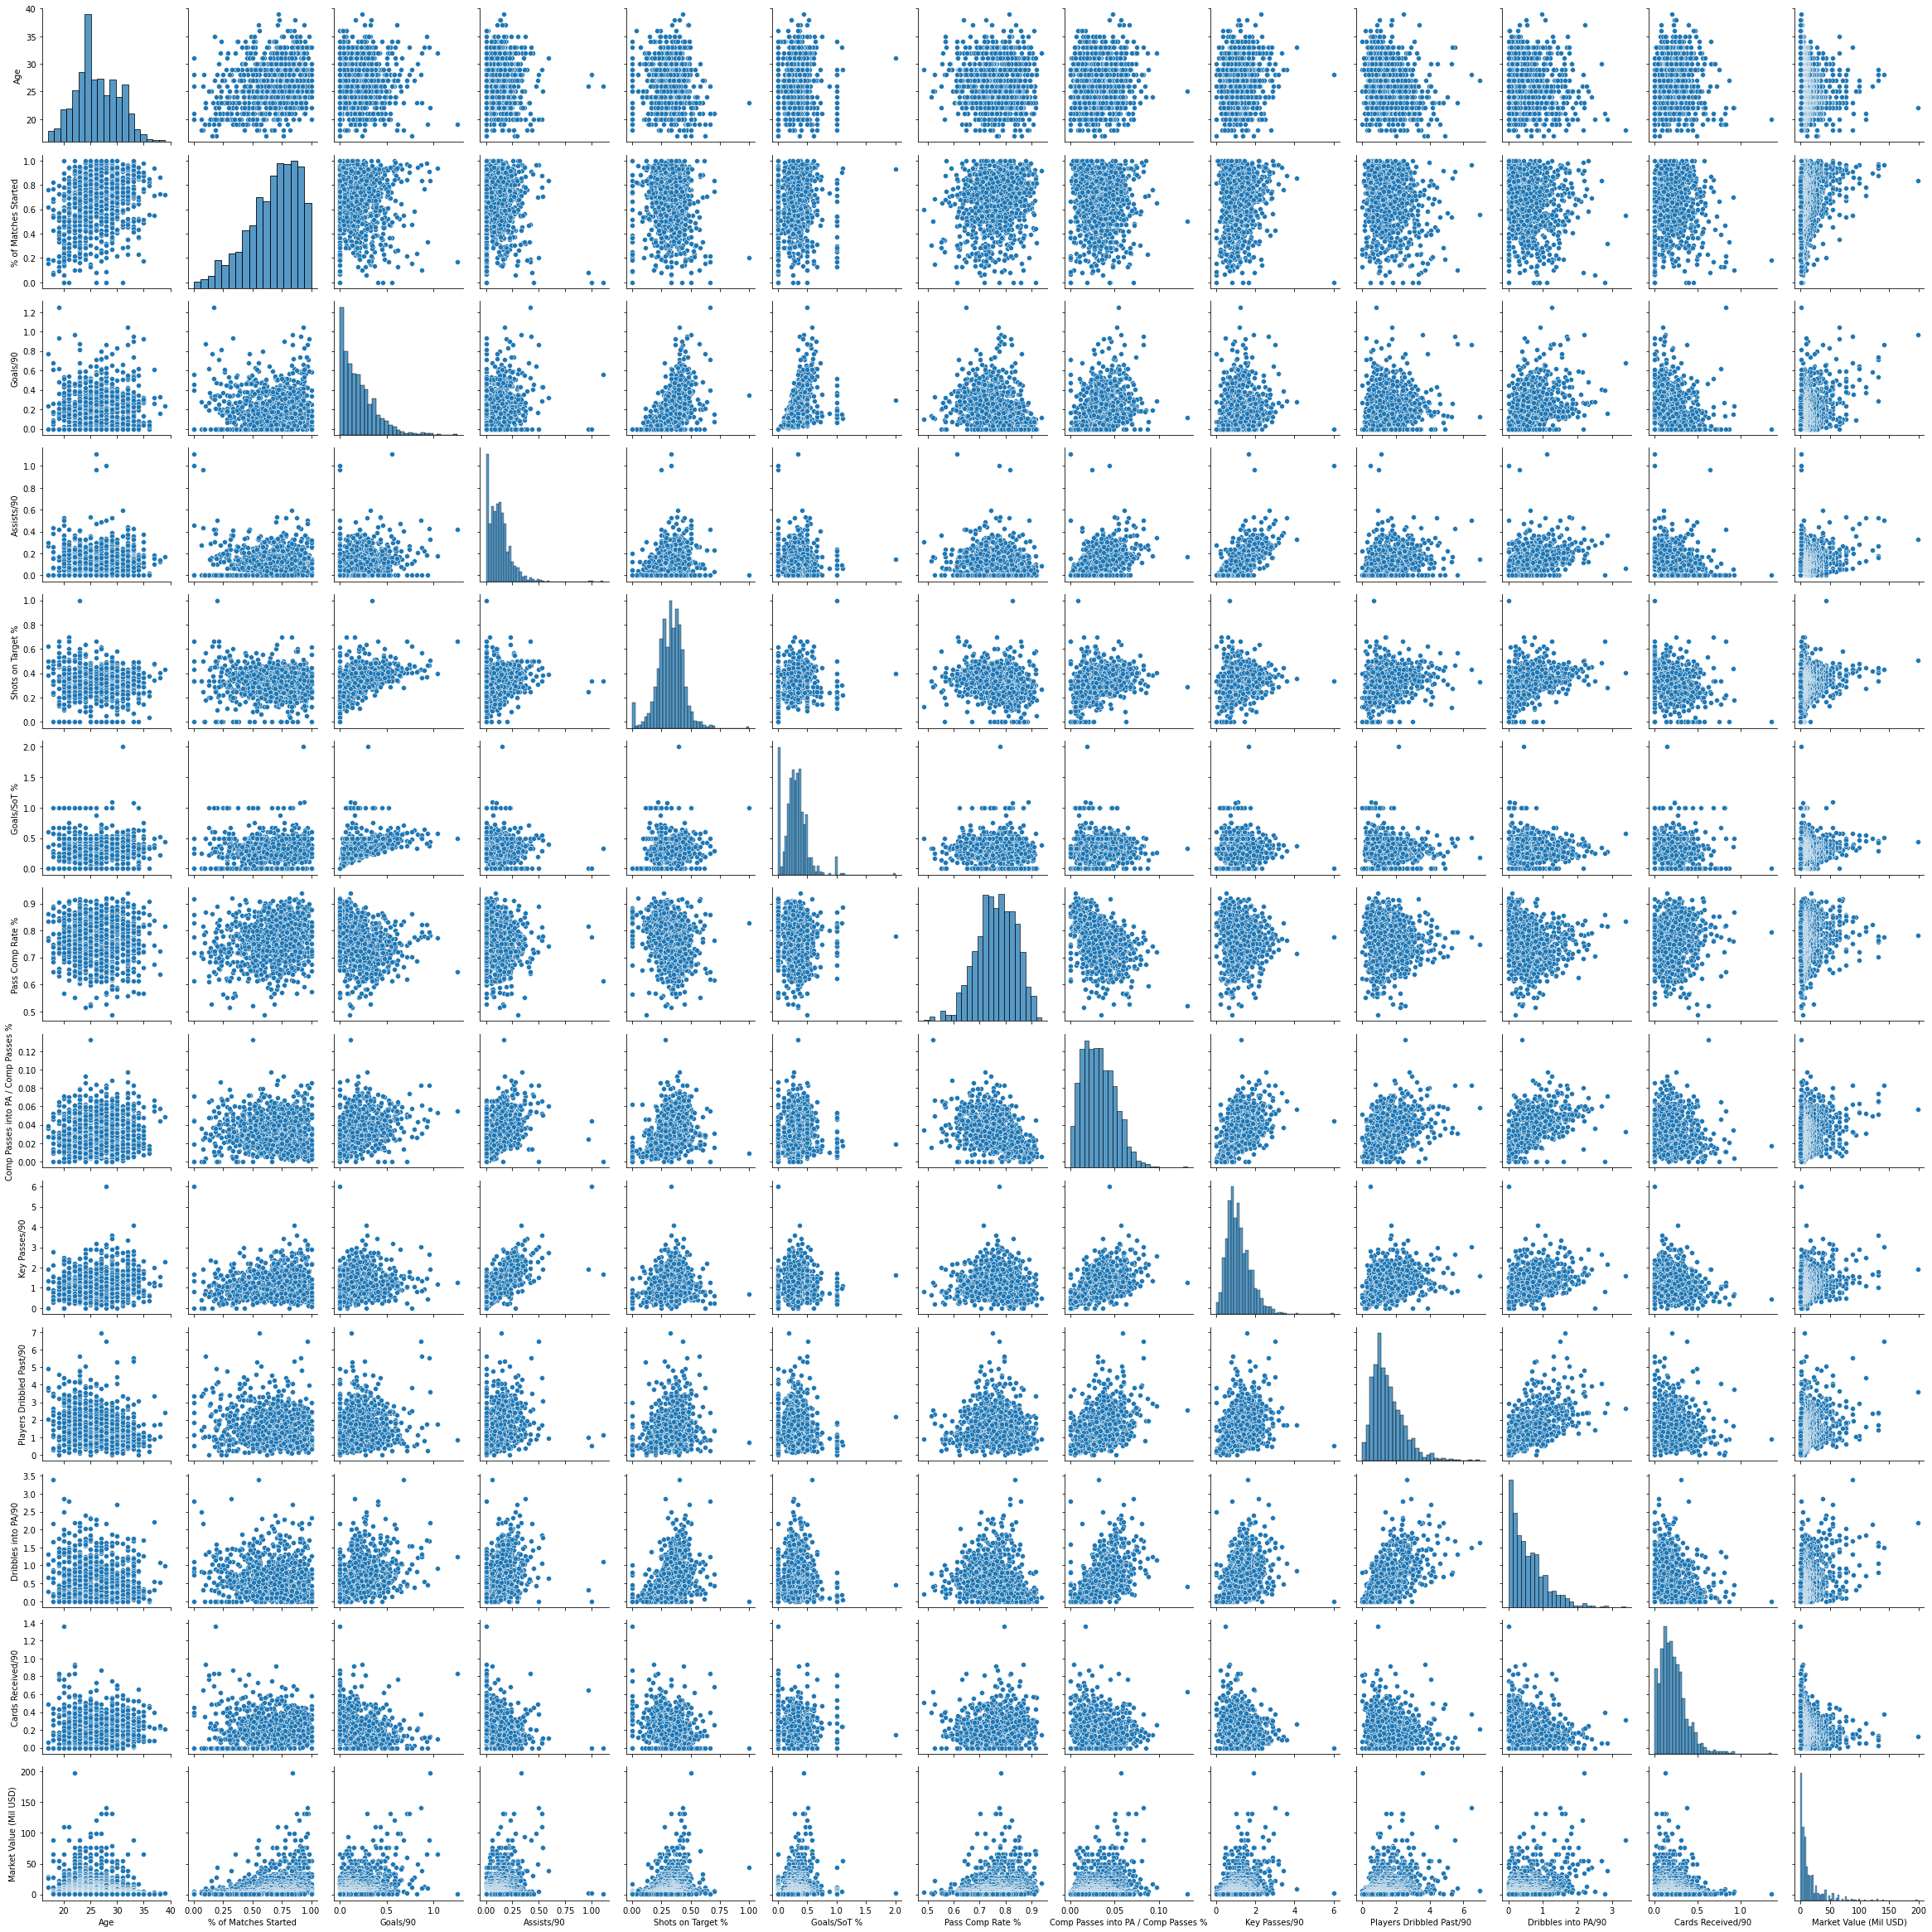

In [22]:
sns.pairplot(df_standardized_ForMid)
plt.tight_layout()
plt.savefig('../Charts/Pairplot.png', dpi=600)

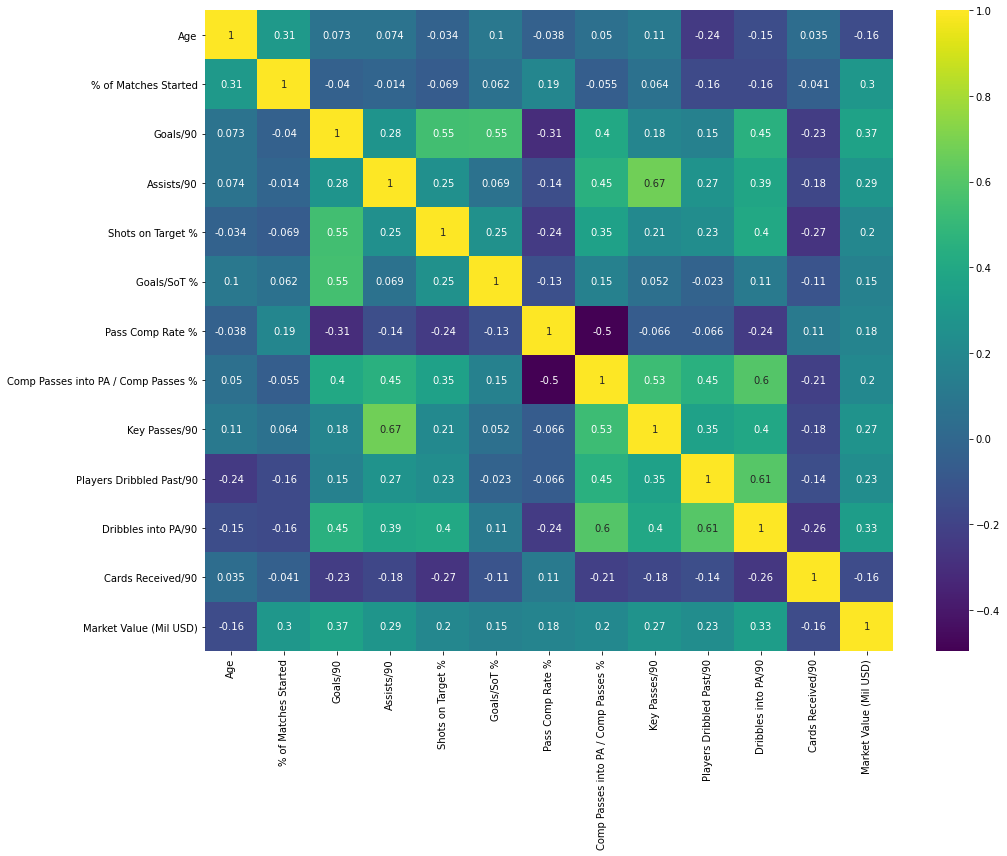

In [23]:
mu.correlation_heatmap(df_standardized_ForMid)
plt.tight_layout()
plt.savefig('../Charts/heatmap.png', dpi=600)

# Watch out for multicollinearity - may want to drop some
# Highly correlated features:
# 1. Assists/90, Key Passes/90: 0.65
# 2. Goals/90, Goals/SoT %: 0.62
# 3. Players Dribbled Past/90, Dribbles into PA/90: 0.61
# 4. Comp Passes into PA/Comp Passes %, Dribbles into PA/90: 0.60
# 5. Goals/90, Shots on Target %: 0.56
# 6. Comp Passes into PA/Comp Passes %, Key Passes/90: 0.51
# 7. Comp Passes into PA/Comp Passes %, Pass Comp Rate %: -0.50
# 8. Comp Passes into PA/Comp Passes %, Players Dribbled Past/90: 0.49

# No. of Correlations higher than 0.35:
# 1. Comp Passes into PA/Comp Passes %: 7
# 2. Dribbles into PA/90: 6
# 3. Key Passes/90: 4
# 4. Goals/90: 4
# 5. Players Dribbled Past/90: 3 
# 6. Shots on Target %: 3
# 7. Assists/90: 3

### 4. Modeling

#### 4.1. Baseline Model - Use all numerical features  
#### 4.2. Cross-Validation - Simple linear, Polynomial, Ridge, Lasso - scaled vs. unscaled
#### 4.3. Model Tuning - Dropping features, Log transformation 

### 4.1. Baseline Model - Use all numerical features

In [24]:
X = df_standardized_ForMid.drop(['Player Name','League','Position','Market Value (Mil USD)'], axis=1)
y = df_standardized_ForMid['Market Value (Mil USD)']

### 4.2. Cross-Validation - Simple linear, Polynomial, Ridge, Lasso 

In [25]:
mu.cross_val(X, y)

Simple linear mean cv adjusted r^2: 0.3582 +- 0.0709
Ridge mean cv adjusted r^2: 0.3611 +- 0.0631
Lasso mean cv adjusted r^2: 0.3521 +- 0.0640
Polynomial mean cv adjusted r^2: -0.3052 +- 0.1966 

Simple linear mean cv RMSE: 15.8806 +- 2.1789
Ridge mean cv RMSE: 15.8608 +- 2.2293
Lasso mean cv RMSE: 15.9631 +- 2.1765
Polynomial mean cv RMSE: 15.7803 +- 2.3129 

Ridge alpha: 10.0
Lasso alpha: 0.1333387208165046


,Lasso Coef
Age,-5.683074
% of Matches Started,6.603432
Goals/90,7.855095
Assists/90,3.211000
Shots on Target %,-0.729308
Goals/SoT %,-0.872194
Pass Comp Rate %,5.892785
Comp Passes into PA / Comp Passes %,1.156538
Key Passes/90,0.302529
Players Dribbled Past/90,0.352479


### 4.3. Model Tuning 

In [26]:
# Dropping features that had coefficients of 0 from the LASSO model

In [27]:
X2 = X.drop(['Shots on Target %', 'Goals/SoT %', 'Cards Received/90'], axis=1)
y2 = df_standardized_ForMid['Market Value (Mil USD)']

In [28]:
mu.cross_val(X2,y2)

Simple linear mean cv adjusted r^2: 0.3738 +- 0.0527
Ridge mean cv adjusted r^2: 0.3758 +- 0.0479
Lasso mean cv adjusted r^2: 0.3736 +- 0.0467
Polynomial mean cv adjusted r^2: 0.2069 +- 0.1412 

Simple linear mean cv RMSE: 15.8719 +- 2.2726
Ridge mean cv RMSE: 15.8565 +- 2.3119
Lasso mean cv RMSE: 15.8859 +- 2.3145
Polynomial mean cv RMSE: 14.8941 +- 1.9350 

Ridge alpha: 10.0
Lasso alpha: 0.14297473975632344


,Lasso Coef
Age,-5.634839
% of Matches Started,6.501232
Goals/90,6.987805
Assists/90,3.226277
Pass Comp Rate %,5.822363
Comp Passes into PA / Comp Passes %,1.056280
Key Passes/90,0.256782
Players Dribbled Past/90,0.322856
Dribbles into PA/90,1.743874


In [29]:
# Again, drop coefficents that are 0 or close to 0 

In [30]:
X3 = X2.drop(['Key Passes/90','Players Dribbled Past/90','Comp Passes into PA / Comp Passes %'], axis=1)
y3 = df_standardized_ForMid['Market Value (Mil USD)']

In [31]:
mu.cross_val(X3,y3)

Simple linear mean cv adjusted r^2: 0.3894 +- 0.0414
Ridge mean cv adjusted r^2: 0.3908 +- 0.0372
Lasso mean cv adjusted r^2: 0.3895 +- 0.0411
Polynomial mean cv adjusted r^2: 0.4720 +- 0.0923 

Simple linear mean cv RMSE: 15.8402 +- 2.3266
Ridge mean cv RMSE: 15.8317 +- 2.3651
Lasso mean cv RMSE: 15.8392 +- 2.3294
Polynomial mean cv RMSE: 13.5421 +- 1.5933 

Ridge alpha: 10.0
Lasso alpha: 0.007115886488714729


,Lasso Coef
Age,-5.827907
% of Matches Started,6.728047
Goals/90,7.113183
Assists/90,3.737397
Pass Comp Rate %,5.612592
Dribbles into PA/90,2.473510


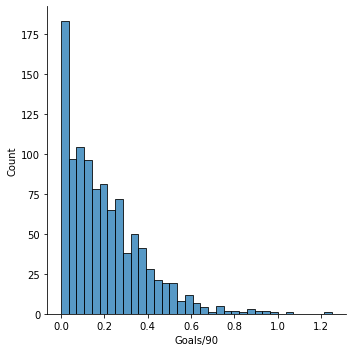

In [32]:
mu.distribution_plot(df_standardized_ForMid, 'Goals/90')
plt.tight_layout()
plt.savefig('../Charts/Goals_90_Dist.png', dpi=600)

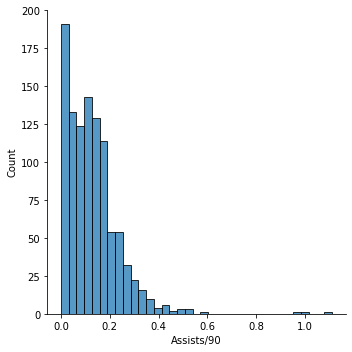

In [33]:
mu.distribution_plot(df_standardized_ForMid, 'Assists/90')
plt.tight_layout()
plt.savefig('../Charts/Assists_90_Dist.png', dpi=600)

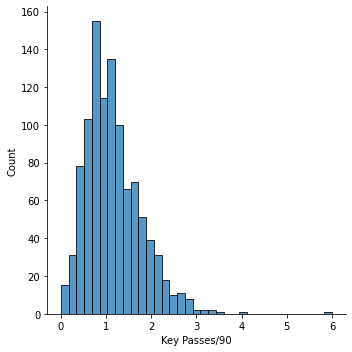

In [34]:
mu.distribution_plot(df_standardized_ForMid, 'Key Passes/90')
plt.tight_layout()
plt.savefig('../Charts/Keypasses_90_Dist.png', dpi=600)

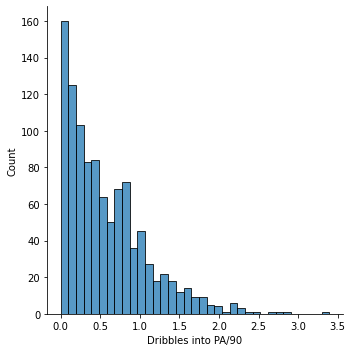

In [35]:
mu.distribution_plot(df_standardized_ForMid, 'Dribbles into PA/90')
plt.tight_layout()
plt.savefig('../Charts/DribblesintoPA_90_Dist.png', dpi=600)

#### Log transformation of right-skewed features

In [36]:
# Log transformation - find right-skewed features:
# 1. Goals/90
# 2. Assists/90
# 3. Dribbles into PA/90
# 4. Market Value (Mil USD)

# Notice the columns that we already removed are also right-skewed - we can keep these columns, log transform, 
# then run the cross-validation again.

# Goals/SoT %
# Comp Passes into PA / Comp Passes %
# Cards Received/90
# Players Dribbled Past/90
# Key Passes/90

In [38]:
columns = [
    'Goals/90', 'Assists/90', 'Goals/SoT %', 'Comp Passes into PA / Comp Passes %',
    'Key Passes/90', 'Players Dribbled Past/90', 'Dribbles into PA/90',
    'Cards Received/90' 
]
df_standardized_ForMid_log = mu.logtransform(df_standardized_ForMid, columns).drop(columns, axis=1)

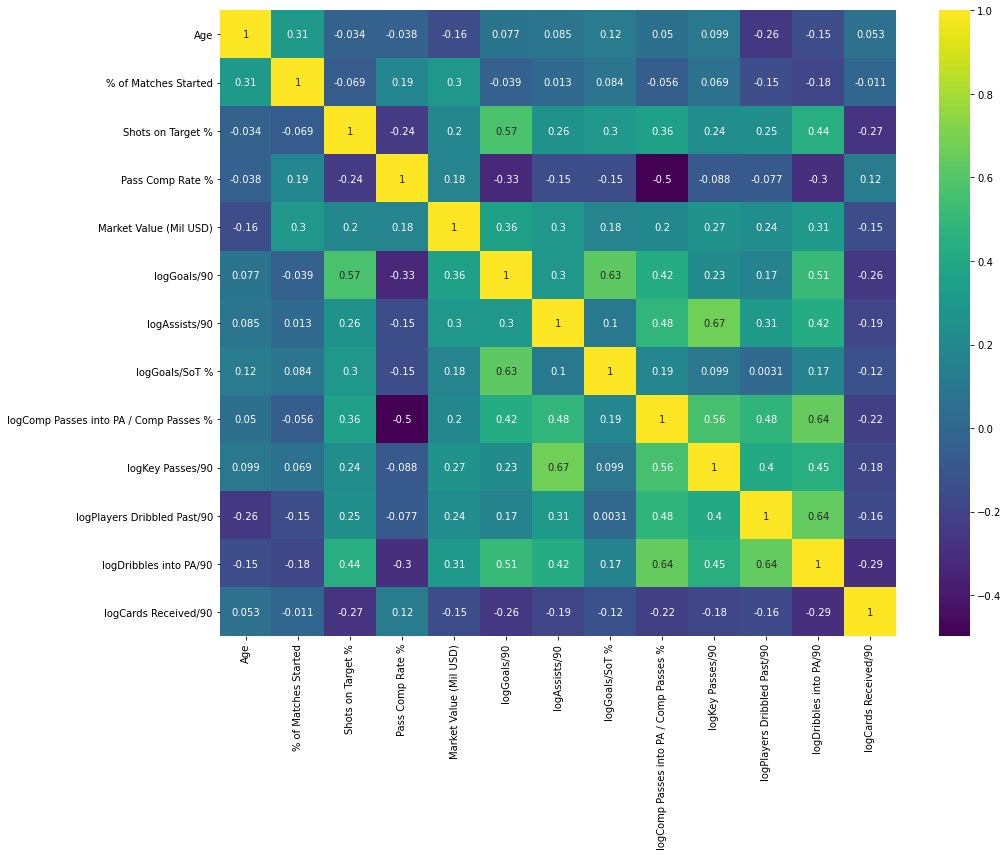

In [40]:
mu.correlation_heatmap(df_standardized_ForMid_log)
plt.tight_layout()
plt.savefig('../Charts/heatmap_log.png', dpi=600)

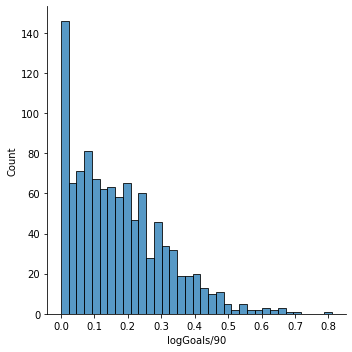

In [41]:
mu.distribution_plot(df_standardized_ForMid_log, 'logGoals/90')
plt.tight_layout()
plt.savefig('../Charts/Goals_90_log_Dist.png', dpi=600)

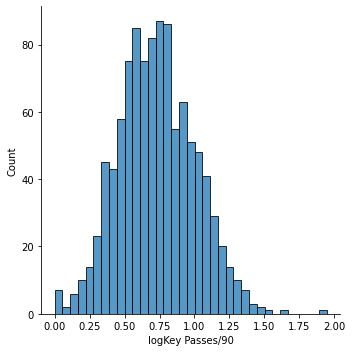

In [42]:
mu.distribution_plot(df_standardized_ForMid_log, 'logKey Passes/90')
plt.tight_layout()
plt.savefig('../Charts/Keypasses_90_log_Dist.png', dpi=600)

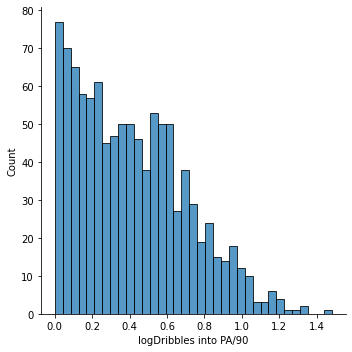

In [43]:
mu.distribution_plot(df_standardized_ForMid_log, 'logDribbles into PA/90')
plt.tight_layout()
plt.savefig('../Charts/DribblesintoPA_90_log_Dist.png', dpi=600)

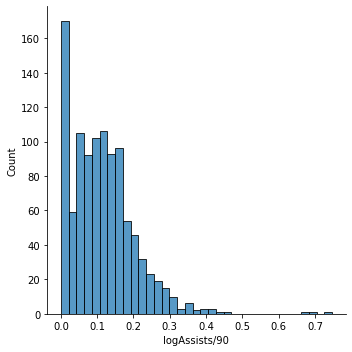

In [44]:
mu.distribution_plot(df_standardized_ForMid_log, 'logAssists/90')
plt.tight_layout()
plt.savefig('../Charts/Assists_90_log_Dist.png', dpi=600)

#### Run cross validation scores on the tuned models and find the best model

In [45]:
X_log = df_standardized_ForMid_log.drop(['Player Name','League','Position','Market Value (Mil USD)'], axis=1)
y = df_standardized_ForMid_log['Market Value (Mil USD)']

In [46]:
mu.cross_val(X_log,y)

Simple linear mean cv adjusted r^2: 0.3569 +- 0.0660
Ridge mean cv adjusted r^2: 0.3595 +- 0.0581
Lasso mean cv adjusted r^2: 0.3563 +- 0.0511
Polynomial mean cv adjusted r^2: -0.1596 +- 0.1475 

Simple linear mean cv RMSE: 15.9231 +- 2.3316
Ridge mean cv RMSE: 15.9064 +- 2.3799
Lasso mean cv RMSE: 15.9524 +- 2.3689
Polynomial mean cv RMSE: 14.8505 +- 1.7845 

Ridge alpha: 10.0
Lasso alpha: 0.14721864237909915


,Lasso Coef
Age,-5.667391
% of Matches Started,6.428617
Shots on Target %,-0.845866
Pass Comp Rate %,6.127878
logGoals/90,8.163331
logAssists/90,3.563032
logGoals/SoT %,-1.182232
logComp Passes into PA / Comp Passes %,1.231495
logKey Passes/90,0.000000
logPlayers Dribbled Past/90,0.583909


In [47]:
# Running LASSO for the log tranformed features produces the same features with zero (or close to zero) coefficients as before.

In [48]:
X2_log = X_log.drop(['Shots on Target %', 'logGoals/SoT %', 'logKey Passes/90', 'logCards Received/90'], axis=1)
y2 = df_standardized_ForMid_log['Market Value (Mil USD)']

In [49]:
mu.cross_val(X2_log, y2)

Simple linear mean cv adjusted r^2: 0.3754 +- 0.0483
Ridge mean cv adjusted r^2: 0.3771 +- 0.0439
Lasso mean cv adjusted r^2: 0.3762 +- 0.0462
Polynomial mean cv adjusted r^2: 0.3515 +- 0.1207 

Simple linear mean cv RMSE: 15.9266 +- 2.4265
Ridge mean cv RMSE: 15.9148 +- 2.4629
Lasso mean cv RMSE: 15.9186 +- 2.4252
Polynomial mean cv RMSE: 14.0047 +- 1.3194 

Ridge alpha: 10.0
Lasso alpha: 0.006833284065664595


,Lasso Coef
Age,-5.839827
% of Matches Started,6.453884
Pass Comp Rate %,6.280842
logGoals/90,7.075171
logAssists/90,3.632866
logComp Passes into PA / Comp Passes %,1.326868
logPlayers Dribbled Past/90,0.519573
logDribbles into PA/90,1.080005


In [50]:
# Dropping 'Players Dribbled Past/90', 'Cards Received/90' and keeping 'Comp Passes into PA / Comp Passes %' produces the highest adjusted R^2

In [51]:
X3_log = X2_log.drop(['logPlayers Dribbled Past/90'], axis=1)
y3 = df_standardized_ForMid_log['Market Value (Mil USD)']

In [52]:
mu.cross_val(X3_log,y3)

Simple linear mean cv adjusted r^2: 0.3804 +- 0.0485
Ridge mean cv adjusted r^2: 0.3820 +- 0.0441
Lasso mean cv adjusted r^2: 0.3803 +- 0.0479
Polynomial mean cv adjusted r^2: 0.4136 +- 0.0899 

Simple linear mean cv RMSE: 15.9111 +- 2.4147
Ridge mean cv RMSE: 15.9010 +- 2.4507
Lasso mean cv RMSE: 15.9128 +- 2.4161
Polynomial mean cv RMSE: 13.8548 +- 1.4633 

Ridge alpha: 10.0
Lasso alpha: 0.006833284065664595


,Lasso Coef
Age,-5.913327
% of Matches Started,6.438212
Pass Comp Rate %,6.355000
logGoals/90,6.996190
logAssists/90,3.645669
logComp Passes into PA / Comp Passes %,1.454128
logDribbles into PA/90,1.375573


### 5. Include League as a Categorical Feature and One-hot Encode 

In [53]:
league_df = pd.get_dummies(df_standardized_ForMid_log['League'], drop_first=True)

In [54]:
df_standardized_ForMid_log = pd.concat([df_standardized_ForMid_log,league_df], axis=1)

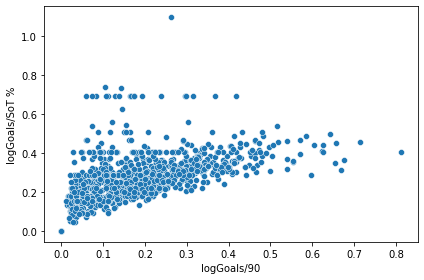

In [55]:
mu.scatterplot('logGoals/90', 'logGoals/SoT %', df_standardized_ForMid_log)
plt.tight_layout()
plt.savefig('../Charts/Goals90_GoalsSoT_scatter.png', dpi=600)

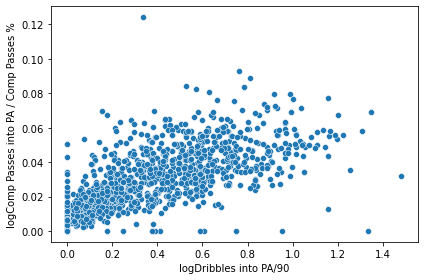

In [56]:
mu.scatterplot('logDribbles into PA/90', 'logComp Passes into PA / Comp Passes %', df_standardized_ForMid_log)
plt.tight_layout()
plt.savefig('../Charts/Dribbles_CompPassPA_scatter.png', dpi=600)

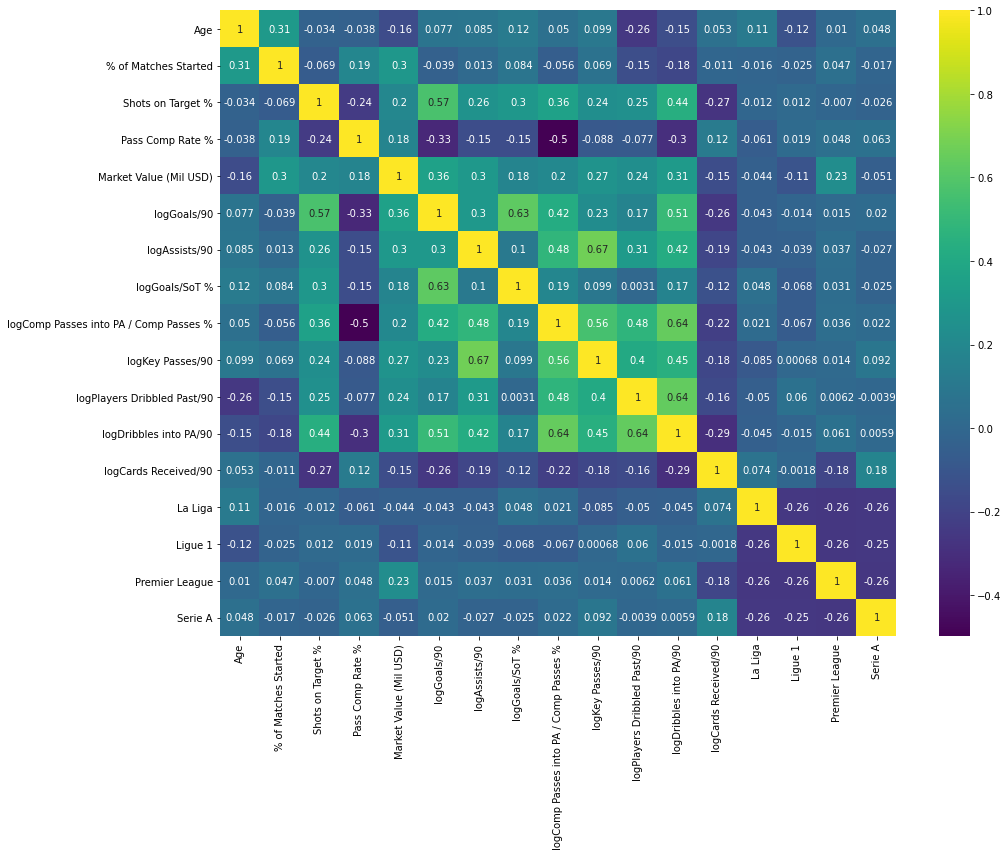

In [57]:
mu.correlation_heatmap(df_standardized_ForMid_log)
plt.tight_layout()
plt.savefig('../Charts/heatmap_log_cat.png', dpi=600)

In [58]:
X_log_league = pd.concat([X_log,league_df], axis=1)
y_league = df_standardized_ForMid_log['Market Value (Mil USD)']

In [59]:
mu.cross_val(X_log_league, y_league)

Simple linear mean cv adjusted r^2: 0.3945 +- 0.0702
Ridge mean cv adjusted r^2: 0.3971 +- 0.0624
Lasso mean cv adjusted r^2: 0.3941 +- 0.0657
Polynomial mean cv adjusted r^2: -5.4549 +- 1.1653 

Simple linear mean cv RMSE: 15.2241 +- 2.1334
Ridge mean cv RMSE: 15.2091 +- 2.1797
Lasso mean cv RMSE: 15.2370 +- 2.1439
Polynomial mean cv RMSE: 14.5092 +- 1.5697 

Ridge alpha: 10.0
Lasso alpha: 0.04192839739980972


,Lasso Coef
Age,-6.227517
% of Matches Started,6.854429
Shots on Target %,-1.070826
Pass Comp Rate %,6.043203
logGoals/90,9.342347
logAssists/90,3.316613
logGoals/SoT %,-2.072716
logComp Passes into PA / Comp Passes %,0.843946
logKey Passes/90,0.748018
logPlayers Dribbled Past/90,1.033081


In [60]:
X2_log_league = X_log_league.drop(['Shots on Target %', 'logCards Received/90', 'Serie A'], axis=1)
y2_league = df_standardized_ForMid_log['Market Value (Mil USD)']

In [61]:
mu.cross_val(X2_log_league, y2_league)

Simple linear mean cv adjusted r^2: 0.4034 +- 0.0695
Ridge mean cv adjusted r^2: 0.4056 +- 0.0624
Lasso mean cv adjusted r^2: 0.4031 +- 0.0642
Polynomial mean cv adjusted r^2: -0.2506 +- 0.2734 

Simple linear mean cv RMSE: 15.2588 +- 2.1138
Ridge mean cv RMSE: 15.2465 +- 2.1587
Lasso mean cv RMSE: 15.2732 +- 2.1367
Polynomial mean cv RMSE: 13.7672 +- 1.2139 

Ridge alpha: 10.0
Lasso alpha: 0.06372743589842578


,Lasso Coef
Age,-6.120697
% of Matches Started,6.760289
Pass Comp Rate %,5.987829
logGoals/90,8.647903
logAssists/90,3.261599
logGoals/SoT %,-2.004947
logComp Passes into PA / Comp Passes %,0.807934
logKey Passes/90,0.585637
logPlayers Dribbled Past/90,1.004284
logDribbles into PA/90,0.259143


In [62]:
X3_log_league = X2_log_league.drop(['logKey Passes/90','logComp Passes into PA / Comp Passes %','Ligue 1', 'logPlayers Dribbled Past/90', 'logGoals/SoT %'], axis=1)
y3_league = df_standardized_ForMid_log['Market Value (Mil USD)']

In [63]:
mu.cross_val(X3_log_league, y3_league)

Simple linear mean cv adjusted r^2: 0.4151 +- 0.0516
Ridge mean cv adjusted r^2: 0.4166 +- 0.0474
Lasso mean cv adjusted r^2: 0.4152 +- 0.0512
Polynomial mean cv adjusted r^2: 0.4078 +- 0.0983 

Simple linear mean cv RMSE: 15.3824 +- 2.1780
Ridge mean cv RMSE: 15.3732 +- 2.2191
Lasso mean cv RMSE: 15.3815 +- 2.1814
Polynomial mean cv RMSE: 13.4232 +- 1.4261 

Ridge alpha: 10.0
Lasso alpha: 0.006833284065664595


,Lasso Coef
Age,-6.139444
% of Matches Started,6.620291
Pass Comp Rate %,5.759422
logGoals/90,7.108467
logAssists/90,4.037156
logDribbles into PA/90,1.791138
La Liga,2.001466
Premier League,3.866391


In [64]:
# Including League as one-hot encoded variables signficantly improves the predictive power of all the models 
# But we need to perform assumption testing for linear regression by looking at the distribution of residuals

### 6. Assumption Testing - Residual Distribution

In [65]:
df_standardized_ForMid_log = mu.residuals(X3_log_league, y3_league, df_standardized_ForMid_log)
df_standardized_ForMid_log.head()

,Player Name,League,Position,Age,% of Matches Started,Shots on Target %,Pass Comp Rate %,Market Value (Mil USD),logGoals/90,logAssists/90,...,logKey Passes/90,logPlayers Dribbled Past/90,logDribbles into PA/90,logCards Received/90,La Liga,Ligue 1,Premier League,Serie A,Predictions,Residuals
0,Kylian Mbappé,Ligue 1,FW,22.0,0.838710,0.504399,0.780389,198.0,0.675221,0.285141,...,1.070296,1.521411,1.161722,0.119474,0,1,0,0,66.812390,131.187610
5,Kevin De Bruyne,Premier League,MF,29.0,0.878505,0.333333,0.763402,132.0,0.251559,0.423994,...,1.525482,0.991090,0.720814,0.084349,0,0,1,0,46.399579,85.600421
2,Harry Kane,Premier League,FW,27.0,0.973214,0.404255,0.701164,132.0,0.539383,0.162473,...,0.708351,0.872447,0.592110,0.130393,0,0,1,0,50.100929,81.899071
3,Sadio Mané,Premier League,FW,28.0,0.940171,0.433099,0.779264,132.0,0.428108,0.150327,...,0.960344,1.205308,0.967622,0.108409,0,0,1,0,51.080788,80.919212
1,Neymar,Ligue 1,MF,28.0,0.966667,0.430435,0.775220,140.8,0.622487,0.406041,...,1.391892,2.011789,0.917326,0.322058,0,1,0,0,61.879736,78.920264


In [66]:
# Remove outliers

In [67]:
df_standardized_ForMid_log = df_standardized_ForMid_log[df_standardized_ForMid_log['Residuals']<13].reset_index(drop=True)
df_standardized_ForMid_log = df_standardized_ForMid_log[(df_standardized_ForMid_log['League']=='Premier League') |
                                                        (df_standardized_ForMid_log['League']=='La Liga') |
                                                        (df_standardized_ForMid_log['Market Value (Mil USD)']>15)].reset_index(drop=True)
df_standardized_ForMid_log = df_standardized_ForMid_log[df_standardized_ForMid_log['Predictions']>10].reset_index(drop=True)

,Player Name,League,Position,Age,% of Matches Started,Shots on Target %,Pass Comp Rate %,Market Value (Mil USD),logGoals/90,logAssists/90,...,logKey Passes/90,logPlayers Dribbled Past/90,logDribbles into PA/90,logCards Received/90,La Liga,Ligue 1,Premier League,Serie A,Predictions,Residuals
0,Harrison Reed,Premier League,MF,25.0,0.769231,0.400000,0.879859,9.9,0.000000,0.096228,...,0.646627,0.339354,0.000000,0.184004,0,0,1,0,22.889807,12.989807
1,Gonzalo Melero,La Liga,MF,27.0,0.630769,0.315789,0.869104,5.5,0.178248,0.070618,...,0.752336,0.693147,0.136576,0.178248,1,0,0,0,18.409320,12.909320
2,Papu Gómez,Serie A,FW,32.0,0.947368,0.378462,0.768634,16.5,0.211683,0.310024,...,1.472364,1.311355,0.921386,0.084717,0,0,0,1,29.146645,12.646645
3,Pascal Groß,Premier League,MF,29.0,0.831776,0.356436,0.710399,7.7,0.157274,0.187983,...,1.275105,0.412738,0.207943,0.092874,0,0,1,0,20.224679,12.524679
4,Carlos Soler,La Liga,MF,24.0,0.858491,0.347458,0.788915,38.5,0.115797,0.145182,...,0.754822,0.728239,0.305382,0.201482,1,0,0,0,26.032359,12.467641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,Christian Kouamé,Serie A,FW,23.0,0.698630,0.320896,0.698770,15.4,0.186665,0.139113,...,0.802604,1.033078,0.524905,0.106107,0,0,0,1,15.751136,0.351136
318,Geoffrey Kondogbia,La Liga,MF,27.0,0.786517,0.232877,0.853718,16.5,0.083035,0.069666,...,0.359701,0.916579,0.069666,0.297375,1,0,0,0,16.793083,0.293083
319,José Campaña,La Liga,MF,27.0,0.957265,0.274510,0.793942,24.2,0.070576,0.183235,...,1.003424,0.926838,0.284478,0.242337,1,0,0,0,24.418375,0.218375
320,Aaron Ramsey,Serie A,MF,30.0,0.625000,0.401575,0.839259,22.0,0.240773,0.282679,...,0.968273,0.745302,0.422857,0.035654,0,0,0,1,21.889738,0.110262


In [68]:
# Rerun cross-validation and find the best model

In [69]:
X_log_league = df_standardized_ForMid_log.drop(['Player Name','League','Position','Market Value (Mil USD)','Predictions', 'Residuals'], axis=1)
y_league = df_standardized_ForMid_log['Market Value (Mil USD)']

In [70]:
mu.cross_val(X_log_league, y_league)

Simple linear mean cv adjusted r^2: 0.5758 +- 0.0614
Ridge mean cv adjusted r^2: 0.5769 +- 0.0621
Lasso mean cv adjusted r^2: 0.5825 +- 0.0671
Polynomial mean cv adjusted r^2: 1.8972 +- 0.3663 

Simple linear mean cv RMSE: 6.3949 +- 0.4684
Ridge mean cv RMSE: 6.3877 +- 0.4935
Lasso mean cv RMSE: 6.3419 +- 0.5508
Polynomial mean cv RMSE: 15.4440 +- 2.6353 

Ridge alpha: 1.0
Lasso alpha: 0.17526307269440158


,Lasso Coef
Age,-6.197442
% of Matches Started,5.716509
Shots on Target %,0.000000
Pass Comp Rate %,6.208287
logGoals/90,7.143470
logAssists/90,1.523452
logGoals/SoT %,0.000000
logComp Passes into PA / Comp Passes %,0.572580
logKey Passes/90,1.204398
logPlayers Dribbled Past/90,-0.000000


In [71]:
X2_log_league = X_log_league.drop(['logPlayers Dribbled Past/90', 'La Liga', 'Serie A','logGoals/SoT %'], axis=1)
y2_league = df_standardized_ForMid_log['Market Value (Mil USD)']

In [72]:
mu.cross_val(X2_log_league, y2_league)

Simple linear mean cv adjusted r^2: 0.6308 +- 0.0658
Ridge mean cv adjusted r^2: 0.6314 +- 0.0651
Lasso mean cv adjusted r^2: 0.6338 +- 0.0615
Polynomial mean cv adjusted r^2: 1.8699 +- 0.2232 

Simple linear mean cv RMSE: 6.2855 +- 0.4726
Ridge mean cv RMSE: 6.2822 +- 0.4776
Lasso mean cv RMSE: 6.2676 +- 0.4829
Polynomial mean cv RMSE: 9.8235 +- 0.7691 

Ridge alpha: 1.0
Lasso alpha: 0.17916070301775466


,Lasso Coef
Age,-6.294353
% of Matches Started,5.811313
Shots on Target %,0.000000
Pass Comp Rate %,6.258748
logGoals/90,7.251076
logAssists/90,1.571798
logComp Passes into PA / Comp Passes %,0.484222
logKey Passes/90,1.274490
logDribbles into PA/90,2.813590
logCards Received/90,0.121448


In [73]:
X3_log_league = X2_log_league.drop(['logComp Passes into PA / Comp Passes %','logCards Received/90', 'Ligue 1','Shots on Target %'], axis=1)
y3_league = df_standardized_ForMid_log['Market Value (Mil USD)']

In [74]:
mu.cross_val(X3_log_league, y3_league)

Simple linear mean cv adjusted r^2: 0.6728 +- 0.0566
Ridge mean cv adjusted r^2: 0.6732 +- 0.0562
Lasso mean cv adjusted r^2: 0.6731 +- 0.0563
Polynomial mean cv adjusted r^2: -24.9098 +- 44.0731 

Simple linear mean cv RMSE: 6.2192 +- 0.4320
Ridge mean cv RMSE: 6.2166 +- 0.4376
Lasso mean cv RMSE: 6.2169 +- 0.4323
Polynomial mean cv RMSE: 13.8189 +- 12.5913 

Ridge alpha: 1.0
Lasso alpha: 0.05471308998772376


,Lasso Coef
Age,-6.534810
% of Matches Started,6.139644
Pass Comp Rate %,6.440156
logGoals/90,7.581532
logAssists/90,1.672327
logKey Passes/90,1.395710
logDribbles into PA/90,3.126683
Premier League,2.962705


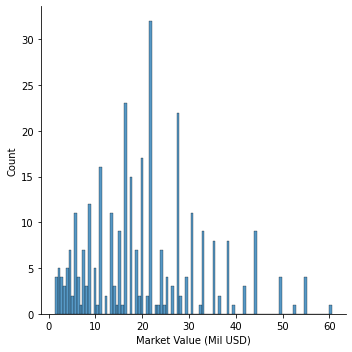

In [76]:
sns.displot(y3_league, bins=100)

In [77]:
df_standardized_ForMid_log = mu.residuals(X3_log_league, y3_league, df_standardized_ForMid_log)
df_standardized_ForMid_log.head()

,Player Name,League,Position,Age,% of Matches Started,Shots on Target %,Pass Comp Rate %,Market Value (Mil USD),logGoals/90,logAssists/90,...,logKey Passes/90,logPlayers Dribbled Past/90,logDribbles into PA/90,logCards Received/90,La Liga,Ligue 1,Premier League,Serie A,Predictions,Residuals
21,Mauro Arambarri,La Liga,MF,25.0,0.972973,0.205357,0.683172,22.0,0.037991,0.047268,...,0.354834,0.739029,0.144004,0.320300,1,0,0,0,4.278700,17.721300
108,Saïd Benrahma,Premier League,MF,25.0,0.454545,0.375000,0.747368,24.2,0.000000,0.296266,...,0.621688,1.669657,0.524524,0.000000,0,0,1,0,7.705648,16.494352
4,Carlos Soler,La Liga,MF,24.0,0.858491,0.347458,0.788915,38.5,0.115797,0.145182,...,0.754822,0.728239,0.305382,0.201482,1,0,0,0,22.607681,15.892319
16,Florian Wirtz,Bundesliga,MF,17.0,0.761905,0.500000,0.764045,26.4,0.213574,0.260531,...,1.066351,1.545534,0.503657,0.057820,0,0,0,0,41.641244,15.241244
74,Jordan Henderson,Premier League,MF,30.0,0.826923,0.238095,0.849118,30.8,0.079407,0.111598,...,0.595887,0.456483,0.132498,0.079407,0,0,1,0,16.412618,14.387382


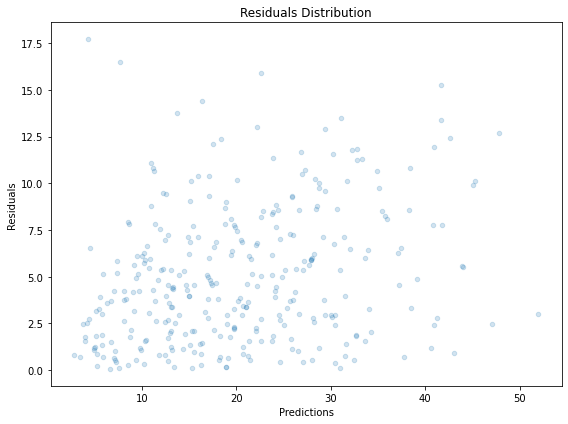

In [78]:
plot = df_standardized_ForMid_log.plot(kind='scatter',
                           x='Predictions',
                           y='Residuals',
                           alpha=0.2,
                           figsize=(8,6))
plt.title('Residuals Distribution')
plt.tight_layout()
plt.savefig('../Charts/residuals.png', dpi=600)

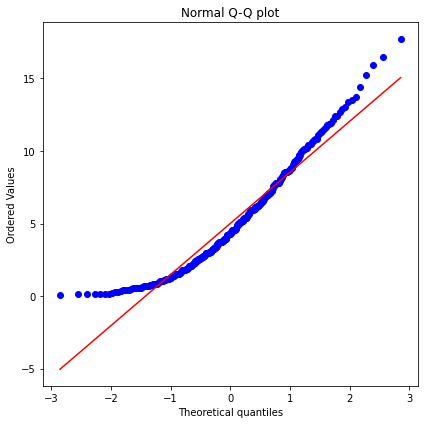

In [79]:
# diagnose/inspect residual normality using qqplot:
plt.figure(figsize=(6,6))
stats.probplot(df_standardized_ForMid_log['Residuals'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.tight_layout()
plt.savefig('../Charts/QQplot.png', dpi=600)

### 7. Final Model Testing

In [80]:
X3_log_league_train, X3_log_league_test, y3_league_train, y3_league_test = train_test_split(X3_log_league, y3_league, test_size=0.2, random_state=10)

# Fitting scaled X3_log_league, y3_league to Ridge regression
scaler_league = StandardScaler()
X3_log_league_train_scaled = scaler_league.fit_transform(X3_log_league_train)
X3_log_league_test_scaled = scaler_league.transform(X3_log_league_test)

ridge_league = RidgeCV()
ridge_league.fit(X3_log_league_train_scaled, y3_league_train)
print(f'Ridge Regression Test adjusted R^2: {1 - (1-ridge_league.score(X3_log_league_test_scaled, y3_league_test))*(len(y3_league_test)-1)/(len(y3_league_test)-X3_log_league_test_scaled.shape[1]-1)}')

Ridge Regression Test adjusted R^2: 0.5766588947781133


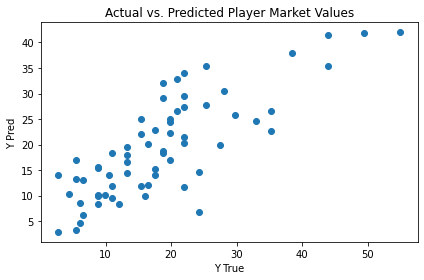

In [81]:
ridge_league_pred = ridge_league.predict(X3_log_league_test_scaled)

plt.scatter(y3_league_test, ridge_league_pred)
plt.xlabel('Y True')
plt.ylabel('Y Pred')
plt.title('Actual vs. Predicted Player Market Values')
plt.tight_layout()
plt.savefig('../Charts/actual_vs_pred.png', dpi=600)

In [82]:
mean_squared_error(y3_league_test, ridge_league_pred)

46.04934147808831

In [83]:
np.sqrt(mean_squared_error(y3_league_test, ridge_league_pred)) 

6.7859665102392235

In [84]:
mean_absolute_error(y3_league_test, ridge_league_pred)

5.454838703031739

### 8. Interpreting Final Results

In [85]:
# Scaled coef of features
ridge_league.coef_

array([-6.7871479 ,  6.06535976,  6.65217286,  7.50276226,  2.09992695,
        1.24912406,  3.14896451,  2.50196282])

In [86]:
# Unscaled coef of features
ridge_league_unscaled_coef = np.true_divide(ridge_league.coef_, scaler_league.scale_)

In [87]:
ridge_league_unscaled_coef

array([ -1.84077679,  35.70156749, 100.58108082,  56.73136567,
        26.64984947,   4.53799976,  10.47535906,   5.1831606 ])

In [88]:
# Interpreting feature coefficients in terms of dollars

ridge_league_unscaled_coef_df = pd.DataFrame(ridge_league_unscaled_coef,index = ['Age', '% of Matches Started',
                                                                  'Pass Comp Rate %', 'logGoals/90', 'logAssists/90',   
                                                                  'logGoals/SoT %', 'logDribbles into PA/90', 
                                                                  'Premier League'],
                                     columns = ['Coefficients'])

In [89]:
ridge_league_unscaled_coef_df

,Coefficients
Age,-1.840777
% of Matches Started,35.701567
Pass Comp Rate %,100.581081
logGoals/90,56.731366
logAssists/90,26.649849
logGoals/SoT %,4.538000
logDribbles into PA/90,10.475359
Premier League,5.183161
